Evaluation of the frame-based matching algorithm
================================================

This notebook aims at evaluating the performance of the Markov Random Field (MRF) algorithm implemented in `stereovis/framed/algorithms/mrf.py` on the three datasets presented above. For each, the following experiments have been done:

* running MRF on each dataset without any SNN-based prior 
* running MRF with prior initialisation from best-performing SNN configuration
* running MRF with prior initialisation and adjustment from motion
* comparing difference between the above scenarios and visually assessing their quality for no ground truth is recorded or computed.

A slightly altered and abbreviated version of this notebook can also be found under `notebooks/evaluation.ipynb`.

In [15]:
%matplotlib inline
import numpy as np
import sys
import skimage.io as skio
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize


from skimage import transform, filters, feature, morphology

sys.path.append("../")
from stereovis.framed.algorithms.mrf import StereoMRF
from stereovis.spiking.algorithms.vvf import VelocityVectorField
from stereovis.utils.frames_io import load_frames, load_ground_truth, generate_frames_from_spikes, split_frames_by_time
from stereovis.utils.spikes_io import load_spikes
from stereovis.utils.config import load_config

In the next we define some usefull functions to load, compute and plot data. They should be used for each dataset independetly and although they export some experiment-specific parametes to the user, other configuration options are "hard-coded" into configuration files -- at least one for each dataset. They define the data paths, camera resolution, frame rate and similar parameters and can be found under `experiments/config/hybrid/experiment_name.yaml`, where `experiment_name` shoud be substituded with the respective name of the experiment. 

In [2]:
def load_mrf_frames(config):
    """
    Load the images used for the frame-based matching. 
    
    Args:
        config: dict, configuration object. Should be loaded beforehand. 
    
    Returns:
        A tuple of numpy arrays with the left-camera frames, right-camera frames and the timestamps 
        provided by the left-camera.
    """
    frames_left, times = load_frames(input_path=os.path.join('..', config['input']['frames_path'], 'left'),
                                     resolution=config['input']['resolution'],
                                     crop_region=config['input']['crop'],
                                     scale_down_factor=config['input']['scale_down_factor'],
                                     simulation_time=config['simulation']['duration'],
                                     timestamp_unit=config['input']['timestamp_unit'],
                                     adjust_contrast=True)
    frames_right, _ = load_frames(input_path=os.path.join('..', config['input']['frames_path'], 'right'),
                                  resolution=config['input']['resolution'],
                                  crop_region=config['input']['crop'],
                                  scale_down_factor=config['input']['scale_down_factor'],
                                  simulation_time=config['simulation']['duration'],
                                  timestamp_unit=config['input']['timestamp_unit'],
                                  adjust_contrast=True)
    return frames_left, frames_right, times 

def load_retina_spikes(config, build_frames=True, pivots=None, buffer_length=10):
    """
    Load the events used for visualisation purposes. 
    
    Args:
        config: dict, configuration object.
        build_frames: bool, whether to load the events in buffered frame-wise manner or as a continuous stream. 
        pivots: list, timestamps which serve as ticks to buffer the events in frames at precise locations. 
            Otherwise, equdistant buffering will be performed, according to the buffer length.
        buffer_length: int, buffer span time in ms.
        
    Returns:
        Buffered left and right retina events, or non-buffered numpy array.
        
    Notes:
        The SNN's output is assumed fixed for this evaluation
        and only the MRF tests are performed. To experiment with the SNN, please see the framework. 
    """
    retina_spikes = load_spikes(input_file=os.path.join('..', config['input']['spikes_path']),
                                resolution=config['input']['resolution'],
                                crop_region=config['input']['crop'],
                                simulation_time=config['simulation']['duration'],
                                timestep_unit=config['input']['timestamp_unit'],
                                dt_thresh=1,
                                scale_down_factor=config['input']['scale_down_factor'],
                                as_spike_source_array=False)
    if not build_frames:
        return retina_spikes
    
    effective_frame_resolution = (np.asarray(config['input']['resolution']) 
                                  / config['input']['scale_down_factor']).astype(np.int32)

    retina_frames_l, times_l = \
        generate_frames_from_spikes(resolution=effective_frame_resolution,
                                    xs=retina_spikes['left'][:, 1],
                                    ys=retina_spikes['left'][:, 2],
                                    ts=retina_spikes['left'][:, 0],
                                    zs=retina_spikes['left'][:, 3],
                                    time_interval=buffer_length,
                                    pivots=pivots,
                                    non_pixel_value=-1)

    retina_frames_r, times_r = \
        generate_frames_from_spikes(resolution=effective_frame_resolution,
                                    xs=retina_spikes['right'][:, 1],
                                    ys=retina_spikes['right'][:, 2],
                                    ts=retina_spikes['right'][:, 0],
                                    zs=retina_spikes['right'][:, 3],
                                    time_interval=buffer_length,
                                    pivots=pivots,
                                    non_pixel_value=-1)
    assert retina_frames_l.shape == retina_frames_r.shape
    return retina_spikes, retina_frames_l, retina_frames_r

def load_snn_spikes(spikes_file, build_frames=True, pivots=None, 
                    buffer_length=10, non_pixel_value=-1):
    """
    Load the SNN output events used as a prior for the frame-based matching.
    
    Args:
        spikes_file: str, filepath for the SNN output events.
        build_frames: bool, whether to buffer the events as frames.
        pivots: list, timestamps for the frames.
        buffer_length: int, buffered frame time span in ms
        non_pixel_value: numerical value for the frame pixels for which there is no event
        
    Returns:
        Buffered frames, timestamps and indices of the events that hass been buffered in each frame accordingly.
    """
    prior_disparities = load_spikes(spikes_file)
    if not build_frames:
        return prior_disparities
    
    effective_frame_resolution = prior_disparities['meta']['resolution']
    prior_frames, timestamps, prior_frame_indices = \
        generate_frames_from_spikes(resolution=effective_frame_resolution,
                                    xs=prior_disparities['xs'],
                                    ys=prior_disparities['ys'],
                                    ts=prior_disparities['ts'],
                                    zs=prior_disparities['disps'],
                                    time_interval=buffer_length,
                                    pivots=pivots,
                                    non_pixel_value=non_pixel_value,
                                    return_time_indices=True)
    return prior_frames, timestamps, prior_frame_indices
      
def eval_mrf(left_img, right_img, max_disp, prior=None, 
             prior_mode='adaptive', prior_const=1.0, n_iter=10, 
             show_outline=False, show_plots=True):
    """
    Run the MRF frame-based matching from given frames and algorithm parameters.
    
    Args:
        left_img: 2d array with the pre-processed left image
        right_img: 2d array with the pre-processed right image
        max_dist: int, largest detectable disparity value
        prior: optionally a 2d array with the prior frame oriented to the left image
        prior_mode: str, mode of incorporating the prior frame. Can be 'adaptive' for mixing proportionally to the 
            data cost, or 'const' for normal mixing.
        prior_const: float, if the prior mode is 'const', this is the mixing coefficient.
        n_iter: int, number of BP iterations 
        show_outline: bool, whether to plot the outline of the objects (using Canny filter)
        show_plots: bool, whether to plot the results
    
    Returns:
        A 2d numpy array with the resulted disparity map.
    """
    img_res = left_img.shape
    mrf = StereoMRF(img_res, n_levels=max_disp)
    disp_map = mrf.lbp(left_img, right_img, prior=prior, 
                       prior_influence_mode=prior_mode, 
                       prior_trust_factor=prior_const,
                       n_iter=n_iter).astype(np.float32)
    disp_map[:, :max_disp] = np.nan
    if not show_plots:
        return disp_map
    
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(10, 8)
    axs[0, 0].imshow(left_img, interpolation='none', cmap='gray')
    axs[0, 0].set_title("Left frame")
    axs[0, 1].imshow(right_img, interpolation='none', cmap='gray')
    axs[0, 1].set_title("Right frame")
    print("Image resolution is: {}".format(img_res))
    
    if show_outline:
        val = filters.threshold_otsu(left_img)
        ref_shape = (left_img > val).reshape(img_res).astype(np.float32)
        ref_outline = feature.canny(ref_shape, sigma=1.0) > 0
        disp_map[ref_outline] = np.nan

    cmap = plt.cm.jet
    cmap.set_bad((1, 1, 1, 1))
    
    depth_map_im = axs[1, 0].imshow(disp_map, interpolation='none')
    axs[1, 0].set_title("Depth frame")
    depth_map_pos = axs[1, 0].get_position()
    cbaxes = plt.axes([depth_map_pos.x0*1.05 + depth_map_pos.width * 1.05, 
                       depth_map_pos.y0, 0.01, depth_map_pos.height])
    fig.colorbar(depth_map_im, cax=cbaxes)
    axs[1, 1].set_visible(False)
    return disp_map

def eval_snn(experiment_name, disparity_max, frame_id, buffer_len=20):
    """
    Visualise the pre-computed SNN output along with the retina input. 
    
    Args:
        experiment_name: str, the name of the experiment which also match an existing config file.
        disparity_max: int, maximum computable disparity
        frame_id: int, the index of the frame (pair of frames) which are used to produce a depth map.
        buffer_len: int, time in ms for the buffer length of retina events
        
    Returns:
        The bufferen SNN output at the timestamps of the frames.
    """
    print("Sample images from experiment: {}".format(experiment_name))
    config = load_config(os.path.join("..", "experiments", "configs", "hybrid", experiment_name + ".yaml"))
    left_frames, right_frames, timestamps = load_mrf_frames(config)
    left_img = left_frames[frame_id]
    right_img = right_frames[frame_id]

    # remove the _downsampled suffix in the experiment name for the pivots
    pivots = np.load(os.path.join("..", "data", "input", "frames", experiment_name[:-12], 
                                  "left", "timestamps.npy")) / 1000.
    retina_spikes, left_retina, right_retina = \
        load_retina_spikes(config, build_frames=True, 
                           pivots=pivots, 
                           buffer_length=buffer_len)
    snn_spikes_file = os.path.join("..", "data", "output", "experiments", 
                                   "best_snn_spikes", experiment_name + '.pickle')
    prior_frames, _, prior_frame_indices = \
        load_snn_spikes(snn_spikes_file, build_frames=True, 
                        pivots=pivots, buffer_length=buffer_len)

    fig, axs = plt.subplots(3, 2)
    fig.set_size_inches(11, 11)
    # fig.tight_layout()

    axs[0, 0].imshow(left_img, interpolation='none', cmap='gray')
    axs[0, 0].set_title("Left frame")
    axs[0, 1].imshow(right_img, interpolation='none', cmap='gray')
    axs[0, 1].set_title("Right frame")
    axs[1, 0].imshow(left_retina[frame_id], interpolation='none')
    axs[1, 0].set_title("Left retina frame")
    axs[1, 1].imshow(right_retina[frame_id], interpolation='none')
    axs[1, 1].set_title("Right retina frame")
    depth_map_snn = axs[2, 0].imshow(prior_frames[frame_id], interpolation='none', vmin=0, vmax=disparity_max)
    depth_map_pos = axs[2, 0].get_position()
    cbaxes = plt.axes([depth_map_pos.x0*1.05 + depth_map_pos.width * 1.05, 
                       depth_map_pos.y0, 0.01, depth_map_pos.height])
    fig.colorbar(depth_map_snn, cax=cbaxes)
    axs[2, 0].set_title("Network depth map")
    axs[2, 1].set_visible(False)
    return prior_frames

def compute_optical_flow(experiment_name, background=None):
    pivots = np.load(os.path.join("..", "data", "input", "frames", experiment_name[:-12], 
                                  "left", "timestamps.npy")) / 1000.
    config = load_config(os.path.join("..", "experiments", "configs", "hybrid", experiment_name + ".yaml"))
    vvf = VelocityVectorField(time_interval=20, 
                              neighbourhood_size=(3, 3), 
                              rejection_threshold=0.005,
                              convergence_threshold=1e-5, 
                              max_iter_steps=5, 
                              min_num_events_in_timespace_interval=30)
    events = load_spikes(input_file=os.path.join('..', config['input']['spikes_path']),
                         resolution=config['input']['resolution'],
                         crop_region=config['input']['crop'],
                         simulation_time=config['simulation']['duration'],
                         timestep_unit=config['input']['timestamp_unit'],
                         dt_thresh=1,
                         scale_down_factor=config['input']['scale_down_factor'],
                         as_spike_source_array=False)

    time_ind, _ = split_frames_by_time(ts=events['left'][:, 0],
                                       time_interval=50,
                                       pivots=pivots)
    velocities = vvf.fit_velocity_field(events['left'][time_ind[frame_id_head], :], assume_sorted=False, 
                                    concatenate_polarity_groups=True)
    
    xs, ys, us, vs = events['left'][time_ind[frame_id_head], 1], \
                     events['left'][time_ind[frame_id_head], 2], \
                     velocities[:, 0], velocities[:, 1]

    fig, axs = plt.subplots(1, 1)
#     fig.set_size_inches(5, 5)
    if background is not None:
        plt.imshow(background)

    colors = np.arctan2(us, vs)

    norm = Normalize()
    if colors.size > 0:
        norm.autoscale(colors)
    colormap = cm.inferno
    axs.invert_yaxis()
    plt.quiver(xs, ys, us, vs, angles='xy', scale_units='xy', scale=1, color=colormap(norm(colors)))
    return xs, ys, us, vs

def adjust_events_from_motion(prior_frame, velocities):
    """
    Modify the position of the events according to the detected motion. As the algorithm for optical flow
    operates on the 3d non-buffered retina events, some additional parameters such as frame resolution etc. will
    be required (unfortunately they cannot be inferred).
    
    Args:
        prior_frame: ndarray, the buffered SNN output used as a prior.
        velocities: tuple, xs, ys, us, vs -- start and end positions of the velocity vectors. 
    
    Returns:
        One adjusted prior frame.
    """
    xs, ys, us, vs = velocities
    # store the velocities onto a 2D image plane which will be queried for a shift
    velocity_lut = np.zeros(prior_frame.shape + (2,))
    for x, y, u, v in zip(xs, ys, us, vs):
        velocity_lut[int(y), int(x), :] = np.array([u, v])
    
    # compute shift based on 8 directional compass
    shifts = np.asarray([(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)], dtype=np.int32)
    compute_shift = lambda x, y: shifts[int(np.floor(np.round(8 * np.arctan2(y, x) / (2 * np.pi)))) % 8] \
                                 if np.linalg.norm([x, y]) > 1. else np.array([0, 0])

    adjusted_frame = np.ones_like(prior_frame) * -1
    # compute the corresponding shift for all detected disparity event_frames
    for row, col in np.argwhere(prior_frame >= 0):
        x, y = velocity_lut[row, col]
        dcol, drow = compute_shift(y, x)
        # going up in the image is equivalent to decrementing the row number, hence the minus in row - drow
        if 0 <= col + dcol < prior_frame.shape[1] and 0 <= row - drow < prior_frame.shape[0]:
            adjusted_frame[row - drow, col + dcol] = prior_frame[row, col]

    return adjusted_frame

def run_mrf_without_prior(experiment_name, disparity_max, frame_id=0, n_iter=5):
    """
    Perform the MRF depth map computation on a pair of images without any prior knowledge. The experiment parameters 
    are loaded from the corresponding configuration yaml file. 
    
    Args:
        experiment_name: str, the name of the experiment which also match an existing config file.
        disparity_max: int, maximum computable disparity.
        frame_id: int, the index of the frame (pair of frames) which are used to produce a depth map.
        n_iter: int, number of MRF BP iterations.
    
    Returns:
        The resolved depth map.
    """
    print("Sample images from experiment: {}".format(experiment_name))
    config = load_config(os.path.join("..", "experiments", "configs", "hybrid", experiment_name + ".yaml"))
    left_frames, right_frames, timestamps = load_mrf_frames(config)
    left_img = left_frames[frame_id]
    right_img = right_frames[frame_id]
    depth_map_raw = eval_mrf(left_img, right_img, disparity_max, n_iter=n_iter)
    return depth_map_raw

def run_mrf_with_prior(experiment_name, disparity_max, prior_frames, 
                       frame_id=0, n_iter=5, prior_mode='const', prior_const=1):
    """
    Run the MRF computation on an image pair using a SNN prior frame in the initialisation phase. Again, load the 
    experiment parameters from a configuration file.
    
    Args:
        experiment_name: str, the name of the experiment which also match an existing config file.
        disparity_max: int, maximum computable disparity
        prior_frames: ndarray, list of all buffered frames from the SNN output.
        frame_id: int, the index of the frame (pair of frames) which are used to produce a depth map.
        n_iter: int, number of MRF BP iterations.
        prior_mode: str, the way of incorporating the prior. Can be `adaptive` or `const`.
        prior_const: float, if the chosen mode is `const` than this is the influence of the prior.
    
    Returns:
        The depth map of the MRF using the prior frame.
    """
    config = load_config(os.path.join("..", "experiments", "configs", "hybrid", experiment_name + ".yaml"))
    left_frames, right_frames, timestamps = load_mrf_frames(config)
    left_img = left_frames[frame_id]
    right_img = right_frames[frame_id]
    depth_map_prior = eval_mrf(left_img, right_img, disparity_max, 
                               prior=prior_frames[frame_id], 
                               prior_mode=prior_mode,  
                               prior_const=prior_const,
                               n_iter=n_iter, show_plots=False)
    return depth_map_prior

def plot_difference_prior_raw(depth_map_raw, depth_map_prior, disparity_max):
    """
    Visualise the outcome from the MRF with the prior and without and show the absolute value difference. 
    
    Args:
        depth_map_raw: ndarray, depth map result of the MRF applied on the frames only.
        depth_map_prior: ndarray, depth map of the MRF applied on the image and prior frames.
        disparity_max: int, maximum detectable disparity, used to normalise the plot colors.
    """
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(12, 20)
    axs[0].imshow(depth_map_prior, interpolation='none', vmax=disparity_max)
    axs[0].set_title("With prior")
    axs[1].imshow(depth_map_raw, interpolation='none', vmax=disparity_max)
    axs[1].set_title("Without prior")
    axs[2].imshow(np.abs(depth_map_raw - depth_map_prior), interpolation='none', vmax=disparity_max)
    axs[2].set_title("Absolute value difference")

def plot_adjusted_prior(experiment_name, frame_id=0):
    """
    Visualise the prior before and after the adjustment.
    
    Args:
        experiment_name: str, name of the experiment to load
        frame_id: int, the index of the frame to plot as background
    """
    config = load_config(os.path.join("..", "experiments", "configs", "hybrid", experiment_name + ".yaml"))
    left_frames, _, _ = load_mrf_frames(config)
    left_img = left_frames[frame_id]

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 16)
    axs[0].imshow(left_img, interpolation='none', cmap='gray')
    axs[0].imshow(prior_frames_head[frame_id_head], interpolation='none', alpha=0.7)
    axs[0].set_title("Reference frame with prior overlayed")

    axs[1].imshow(left_img, interpolation='none', cmap='gray')
    axs[1].imshow(adjusted_events, interpolation='none', alpha=0.7)
    axs[1].set_title("Reference frame with adjusted prior overlayed")

## MRF on frames without prior information

The following experiment provides a baseline for the stereo-matching performance of the MRF algorothm. 
For an algorithm test on a standard stereo benchmark dataset see the notebook `MRF_StereoMatching.ipynb`. These results also provide a baseline for the next experiment in which prior information is included. For the sake of completeness, a [third-party algorithm](http://www.ivs.auckland.ac.nz/quick_stereo/index.php) was applied on a subset of the data to compare against our MRF implementation. The results are included in the submitted data (see `data/output/demo/online_algorithm`).

### Head experiment

Sample images from experiment: head_downsampled
Image resolution is: (60, 70)


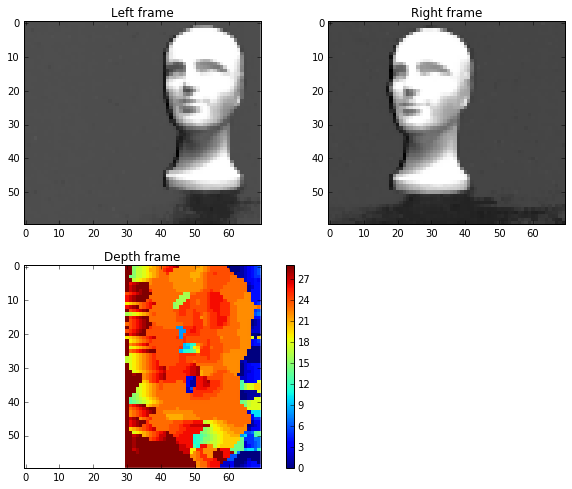

In [3]:
experiment_name = 'head_downsampled'
disparity_max_head = 30 # note that these should be scaled if the scale factor in the config file is changed.
frame_id_head = 40

depth_map_raw_head = run_mrf_without_prior(experiment_name, disparity_max_head, frame_id=frame_id_head, n_iter=5)

**Result Analysis:** 
The head is mostly correctly matched, with some errors in the middle. However, if one increases the number of iterations, then in some cases (different `frame_id`s) these spots tend to disappear. 

Another interesting effect is the misclassified backgorund area on the left side of the head and the correctly classified right side. This can be explained as follows: when comparing the left and right images for the zero disparity case, the background of the two images overlap and due to the homogeneity of the color, the energy values for the right-side background pixels are quite small and the algorithm correctly assigns the small disparity. On the left side however, the background, albeit not really shifted, is occluded from the object in the right image and the nearest matching point to the left of the object (the direction of search) is some 26-27 pixels apart from the reference location. This inevitably produces the wrong depth values on the left side of the reference object. 

Altough the situation below the head statue is different, the algorithm produces unsatisfying results due to the absence of corresponding pixels (as the shadow is not the same in the left and the right image, and the signal from neighbours from above gets propagated to the lower rows of the depth image). 

### Checkerboard experiment

Sample images from experiment: checkerboard_downsampled
Image resolution is: (60, 80)


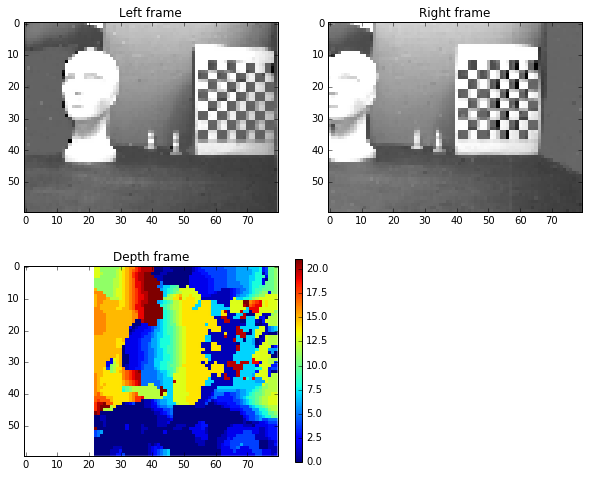

In [4]:
experiment_name = 'checkerboard_downsampled'
disparity_max_checkerboard = 22 # note that these should be scaled if the scale factor in the config file is changed.
frame_id_checkerboard = 40

depth_map_raw_checkerboard = run_mrf_without_prior(experiment_name, disparity_max_checkerboard, 
                                                   frame_id=frame_id_checkerboard, n_iter=5)

**Result Analysis:** 
The outcome of this experiment shows that the MRF is producing good results for the regions which can be matched unambigously, such as object edges. The detected disparities for the regions with homogeneuos colors, e.g. the floor or the wall are mostly incorrect. Nevertheless, the pixel correspondece there is not trivially computable and without any additional knowledge, such as "the floor spans perpendicularly to the image plane" no known to us matching algorithm will be able to generate an adequate depth map. In the experiment with the checkerboard, special difficulty is posed by the repetitive patterns, which in some frames (e.g. No. 40) is fully visible and has therefore a globally optimal matching configuration. There is, however, no guarantee that this configuraiton will be found by the algorithm and in practice we see that only a small portion is correctly matched. 

### Boxes and cones experiment

Sample images from experiment: boxes_and_cones_downsampled
Image resolution is: (60, 80)


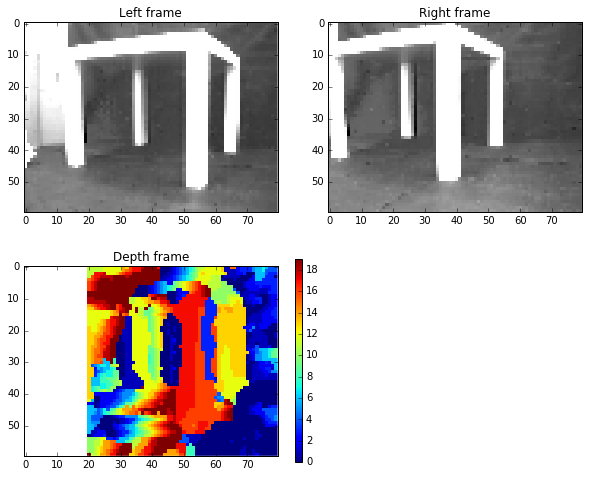

In [5]:
experiment_name = 'boxes_and_cones_downsampled'
disparity_max_boxes = 20 # note that these should be scaled if the scale factor in the config file is changed.
frame_id_boxes = 20

depth_map_raw_boxes = run_mrf_without_prior(experiment_name, disparity_max_boxes, 
                                            frame_id=frame_id_boxes, n_iter=5)

**Result Analysis:**
Some depth maps from frames in this dataset are particularly badly computed as they are overexposed and wash out the object edges. Although the first several frames of the video present a table with sharply outlined edges, some parts which are present in the reference image are missing from the target one, which makes their matching impossible and hinders the correspondence assignment of the visible sections. It is worth putting more effort into pre-processing, such the contrast it normalised locally and overexposed areas do not affect the global contrast normalisation.

## MRF on frames with prior information from SNN output

This experiment will take the pre-computed depth events from the spiking network and will run the MRF on the same data. This time however the initial state of the random field will be computed as a convex combination between the data (i.e. image differences) and the prior. The reader is encouraged to play with the parameters. The arguably well-performing parameters are set as the default in the cell below.

### Head experiment

Sample images from experiment: head_downsampled


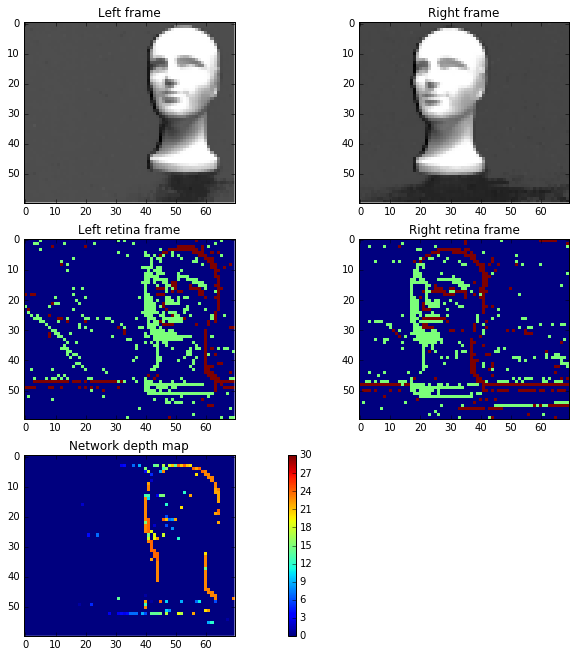

In [6]:
experiment_name = 'head_downsampled'
prior_frames_head = eval_snn(experiment_name, disparity_max_head, frame_id=frame_id_head, buffer_len=20) 

The prior frame, obtained from the buffered SNN output in the time interval `buffer_len` ms before the actual frames, is mixed with the data-term computed in the image difference operation. The mixing coefficient can be proportional to the difference term, which has the following interpretation: _the lower the matching confidence from the data, the higher the prior influence should be_.  

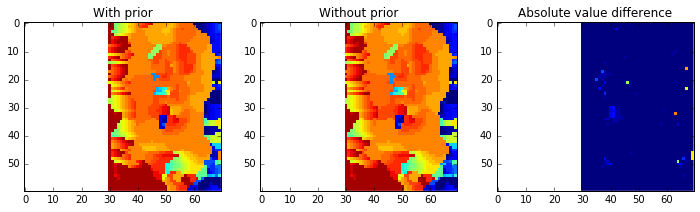

In [7]:
depth_map_prior_head = run_mrf_with_prior(experiment_name, disparity_max_head, prior_frames_head, 
                                          frame_id=frame_id_head, n_iter=5, prior_mode='const', 
                                          prior_const=1)
plot_difference_prior_raw(depth_map_raw=depth_map_raw_head, 
                          depth_map_prior=depth_map_prior_head, 
                          disparity_max=disparity_max_head)

Part of this experiment is to evaluate the contribution of the prior with varying prior constants. Below we plot the results from several independent evaluations with the `prior_const` ranging in [0, 0.1, 0.5, 1, 2, 10, 100] and finaly the result from the adaptive mode.

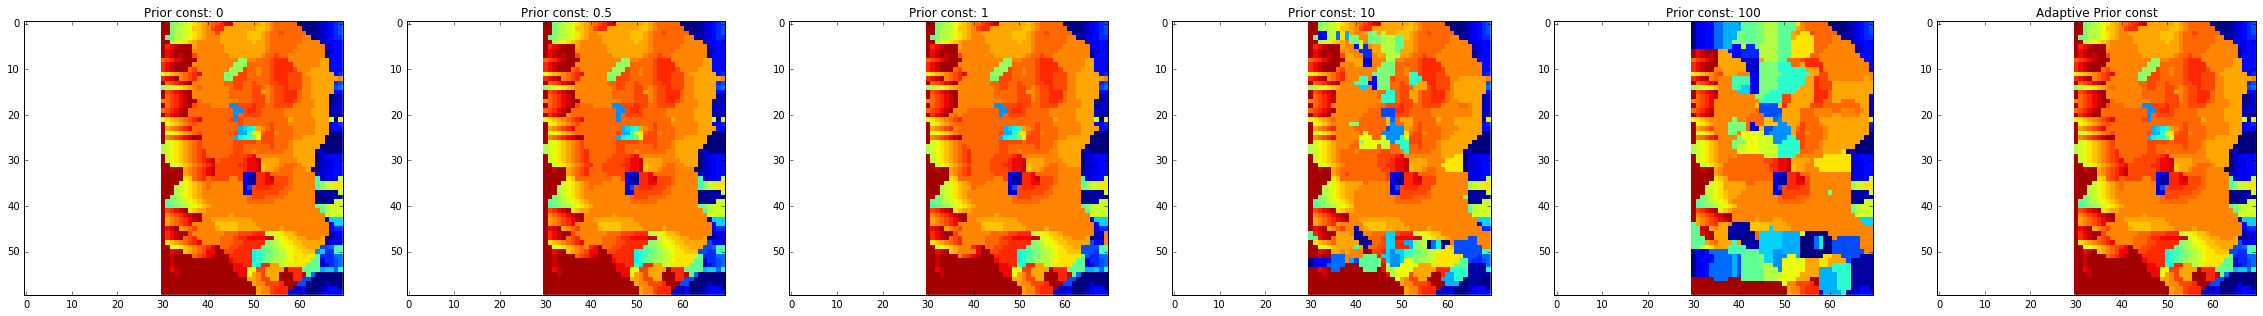

In [8]:
prior_consts = [0, 0.5, 1, 10, 100]
depth_maps = []

fig, axs = plt.subplots(1, len(prior_consts)+1)
fig.set_size_inches(40, 40)
for i, p_c in enumerate(prior_consts):
    depth_map = run_mrf_with_prior(experiment_name, disparity_max_head, prior_frames_head, 
                                   frame_id=frame_id_head, n_iter=5, prior_mode='const', 
                                   prior_const=p_c)
    axs[i].imshow(depth_map, interpolation='none', vmax=disparity_max_head)
    axs[i].set_title("Prior const: {}".format(p_c))
depth_map = run_mrf_with_prior(experiment_name, disparity_max_head, prior_frames_head, 
                               frame_id=frame_id_head, n_iter=5, prior_mode='adaptive')
axs[i+1].imshow(depth_map, interpolation='none', vmax=disparity_max_head)
axs[i+1].set_title("Adaptive Prior const")

**Result Analysis:** 
In some examples the prior has visually deteriorated the results (especially if taken with great influence, i.e, >> 1) and in the rest of the cases it hasn't change much of the quality of the depth map. The former is due to the noisy output that the SNN produces on these datasets and the latter - due to its sparsity. In any case, these results do not support the claim that using SNN as prior initialisation for the MRF will improve the quality of the depth map.

### Checkerboard experiment

Sample images from experiment: checkerboard_downsampled


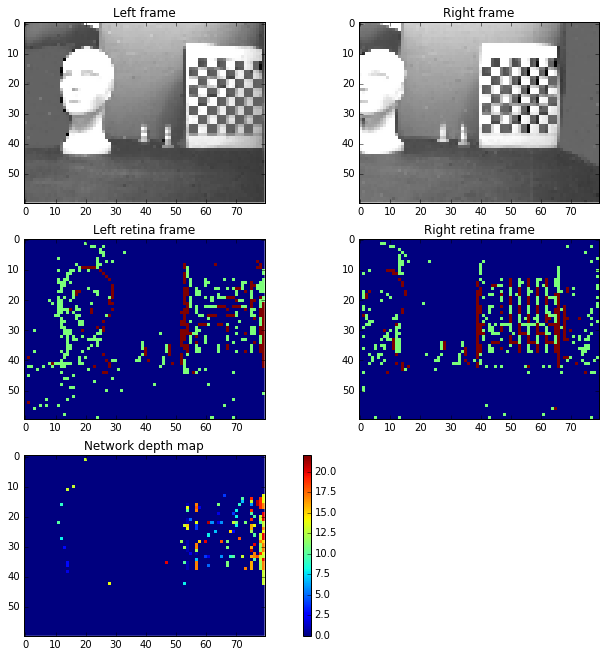

In [9]:
experiment_name = 'checkerboard_downsampled'
prior_frames = eval_snn(experiment_name, disparity_max_checkerboard, frame_id=frame_id_checkerboard, buffer_len=20) 

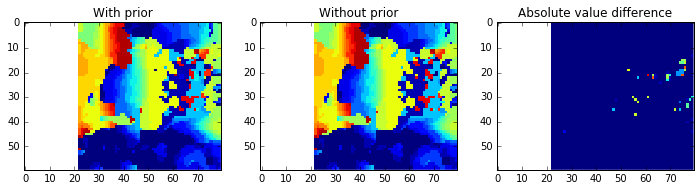

In [10]:
depth_map_prior_checkerboard = run_mrf_with_prior(experiment_name, disparity_max_checkerboard, prior_frames, 
                                                  frame_id=frame_id_checkerboard, n_iter=5, prior_mode='const', 
                                                  prior_const=1)
plot_difference_prior_raw(depth_map_raw=depth_map_raw_checkerboard, 
                          depth_map_prior=depth_map_prior_checkerboard, 
                          disparity_max=disparity_max_checkerboard)

**Result Analysis:** 
The same observations as in the _head experiment_: prior doesn't change much, and if it does, then the depth map has not become better in quality.

### Boxes and cones experiment

Sample images from experiment: boxes_and_cones_downsampled


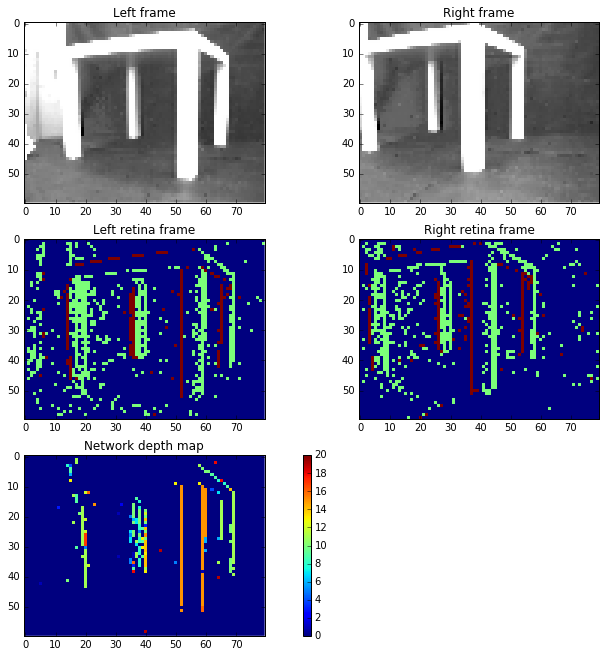

In [11]:
experiment_name = 'boxes_and_cones_downsampled'
prior_frames = eval_snn(experiment_name, disparity_max_boxes, frame_id=frame_id_boxes, buffer_len=20) 

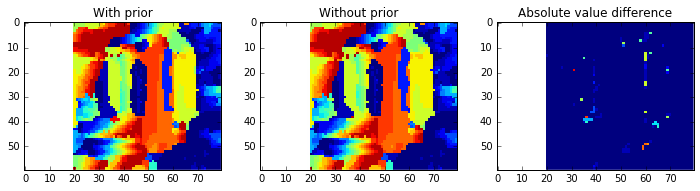

In [12]:
depth_map_prior_boxes = run_mrf_with_prior(experiment_name, disparity_max_boxes, prior_frames, 
                                           frame_id=frame_id_boxes, n_iter=5, prior_mode='const', 
                                           prior_const=1)
plot_difference_prior_raw(depth_map_raw=depth_map_raw_boxes, 
                          depth_map_prior=depth_map_prior_boxes, 
                          disparity_max=disparity_max_boxes)

**Result Analysis:**
Same as above.

## Inspecting the spatial precision of the prior

Since the prior is an accumulated information from the past, and motion is present, it can happend that the SNN output will have spikes on locations which are slightly off form the gray-scale image. If this is the case (which, by the way, is not easily detectable in an automatic fashion) then one can try to compute the motion of the object and adapt the SNN output accordingly. An optical flow algorithm on the SNN events is applied to estimate the future posiiton of the object and the shift is added to the prior. 

We will perform this experiment on the _head_ dataset only, as this is rather unnecessary evaluation and serves only to show that this approach has been considered. Feel free to try on different frames and/or datasets. The optical flow algorithm is implemented according to _Benosman, Ryad, et al., "Event-based visual flow."_ [10], which in short is based on fitting a plane in 3D space-time (2D image space and 1D time dimensions), where the inverse of the slopes of the plane in the orthogonal _x_, _y_ directions (partial derivatives) are used to compute the velocities.

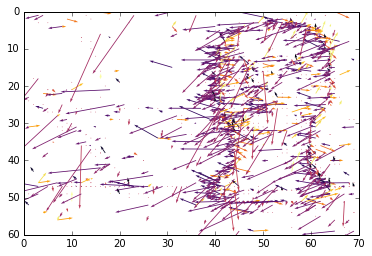

In [13]:
experiment_name = 'head_downsampled'

xs, ys, us, vs = compute_optical_flow(experiment_name)

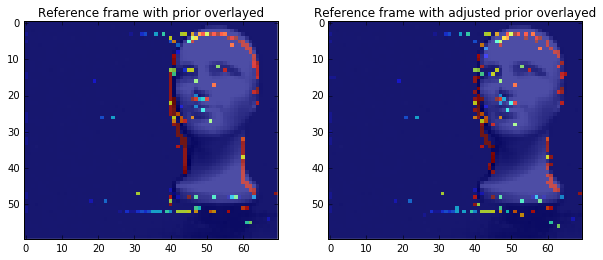

In [14]:
pivots = np.load(os.path.join("..", "data", "input", "frames", experiment_name[:-12], 
                                  "left", "timestamps.npy")) / 1000.
adjusted_events = adjust_events_from_motion(prior_frames_head[frame_id_head], (xs, ys, us, vs))
plot_adjusted_prior(experiment_name, frame_id=frame_id_head)

**Result Analysis:** 
Since the prior adjustment did not turn out to be beneficial, we decided to stop any furhter analysis of the performance. In a different application or under different circumstances (e.g. when immediate depth SNN spikes cannot be computed and older result should be extrapolated in the future) this technique might prove helpful.